Steane Code logical operation test software decoding
============================================

This workbook checks the software decoding of a Bell state formed from two Steane Code qubits.  

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474 

2. Set up physical Hadamard, CX and X to produce a physical Bell pair.

2. Set up logical Hadamard, CX and X to produce a logical Bell pair.

3. Set up the ancilla for the logical qubits

4. Introduce random X and Z errors

5. Correct the logical data qubits using decoding software.

Import the necessary function modules, including the SteaneCodeLogicalQubit class and helper functions.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    summarise_logical_counts,
    mean_of_list,
    calculate_standard_error,
    flip_code_words, 
    correct_qubit,
    convert_codewords,
    look_up_data,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so that the process flow can be controlled from one place:

In [2]:
DATA_QUBITS = 7
ANCILLA_QUBITS = 3
SPACE = ' '
FACTOR_LIST = [1]
TITLE1 = 'Bell pair fidelity with noise free ancilla '

#use standard gate set without transpilation
SINGLE_GATE_SET  = ['id', 'x', 'y', 'z', 'h']
TWO_GATE_SET = ['cx', 'cz']

NOISE = False                           #Test with noise
ADD_ERRORS = True                       #Introduce errors
SHOTS = 1000                            #Number of shots to run
MEASURE_NOISE = 0.0046                  #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.000366     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022           #Two gate noise 
ITERATIONS = 2
SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the logical zero from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


In [5]:
#carryout a bit flip of the list of codewords to find the codewords for the logical one.
flipped_codewords = flip_code_words(codewords)

In [6]:
#The allowed codewords for a single qubit Bell pair
bell_valid_codewords = ['01', '10']

In [7]:
#function to print time
def print_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    return

Physical qubits circuit for Bell pair
-------------------------------------------------

Function module to set up a Bell pair with two physical qubits.

In [8]:
print()
print('Physical qubits Bell pair')
error_rate_list = []
qr = QuantumRegister(2,'code_qubit')     # Two code QBits
cr = ClassicalRegister(2,'syndrome_bit') # Two registers
qc = QuantumCircuit(qr, cr)
qc.h(qr[0])
qc.x(qr[1])
qc.cx(qr[0],qr[1])
qc.measure(qr, cr)
#initialise circuit
if NOISE:
    noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                            TWO_GATE_DEPOLARISING, SINGLE_GATE_SET, TWO_GATE_SET
                           )
if NOISE:
    result = execute(qc, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
else:
    result = execute(qc, SIMULATOR, shots = SHOTS).result()
counts = result.get_counts(qc)
count_valid, count_invalid, _ = count_valid_output_strings(counts, bell_valid_codewords, 0)
print(f'The results are {counts}')
print(f'Valid codewords {bell_valid_codewords}')      
error_rate = count_invalid / SHOTS
#print(f'The error rate is {error_rate:.4f}')
#print()
error_rate_list.append(error_rate)
mean_error_physical = mean_of_list(error_rate_list)
standard_deviation_physical, standard_error_physical = calculate_standard_error(error_rate_list)
print(f'The mean error rate is {mean_error_physical:.8f} and the standard error is {standard_error_physical:.8f}')


Physical qubits Bell pair
The results are {'01': 506, '10': 494}
Valid codewords ['01', '10']
Unable to carry out standard error calcuation with one point. 
Standard error of 0 used.
The mean error rate is 0.00000000 and the standard error is 0.00000000


Logical Bell pair
-----------------------

Function module to set up the Bell pair with two logical qubits.

In [9]:
def set_up_circuit():
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords)
    for index in range(2):
        qubit.set_up_logical_zero(index)
    qubit.barrier()
    if ADD_ERRORS:
        qubit.force_X_error(6, 0)
        qubit.force_Z_error(2, 1)
        qubit.force_X_error(2, 1)
    qubit.logical_gate_H(0)
    qubit.logical_gate_X(1)    
    qubit.logical_gate_CX(0, 1)
    qubit.barrier()
    for index in range(2):
        qubit.set_up_ancilla(index)
        qubit.barrier()
        qubit.logical_measure_data(index)
        qubit.logical_measure_ancilla(index)
    return(qubit)

Function module to execute the logical Bell pair.  For items in the counts dictionary the data qubits are corrected based on the ancilla measurements.  Each data qubit measurements is then decoded to:
 - 0 if the bit string is in the set of logical zero bitstring
 - 1 if the bit string is in the set of logical one bitstring
 - 2 if the bitstring is outside the codespace of valid bitstrings

A check is made to find out if the string of two bits after decoding is in the set of valid bell pairs {'01' and '10'}
Finally the results of the calculation are summarised and returned.

In [10]:
print()
print('Logical qubits Bell pair')
corrected_key = ''
invalid_list = []
valid_list = []
corrected_counts = {}
new_counts = {}
qubit = set_up_circuit()
if NOISE:
        noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                                TWO_GATE_DEPOLARISING, SINGLE_GATE_SET , TWO_GATE_SET, 
                                )
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
counts = result.get_counts(qubit)
print(f'The results are {counts}')
corrected_data = []
for key, values in counts.items():
    #print('key, values', key, values)
    # Z ancilla2
    key0 = key.split()[0]
    # X ancilla2
    key1 = key.split()[1]
    #data qubits2
    key2 = key.split()[2]
    # Z ancilla1
    key3 = key.split()[3]
    # X ancilla1
    key4 = key.split()[4]
    #data qubits1
    key5 = key.split()[5]
    corrected_data0 = correct_qubit(key2, key0, DATA_QUBITS)
    corrected_data1 = correct_qubit(key5, key3, DATA_QUBITS)
    corrected_key = key0 + SPACE + key1 + SPACE + corrected_data0 + SPACE
    corrected_key = corrected_key + key3 + SPACE + key4 + SPACE + corrected_data1
    value_found = corrected_counts.get(corrected_key)
    if value_found:
        corrected_counts[corrected_key] = value_found + values
    else:
        corrected_counts.update({corrected_key: values})  
new_counts = summarise_logical_counts(corrected_counts, codewords, flipped_codewords, 2, 5)  
print(f'The corrected results are {new_counts}')
count_valid, count_invalid, _ = count_valid_output_strings(new_counts, bell_valid_codewords, 0)
invalid_list.append(count_invalid)
valid_list.append(count_valid)
mean_invalid = mean_of_list(invalid_list)
total_valid = sum(valid_list)
total_invalid = sum(invalid_list)
total_all = total_valid + total_invalid
print(f'There were {total_valid} valid shots and {total_invalid} invalid shots giving {total_all} in total')
mean_error_logical = mean_invalid / SHOTS
standard_deviation, standard_error = calculate_standard_error(invalid_list)
standard_error_logical = standard_error / SHOTS
print(f'On average there are {mean_invalid:.1f} invalid codewords with a standard error of {standard_error:.1f}')
print(f'The mean error rate for a single qubit is {mean_error_logical :.8f} and the standard error is {standard_error_logical:.8f}')


Logical qubits Bell pair
The results are {'110 110 0000011 000 001 0000000': 10, '110 110 0000011 000 001 0011110': 4, '110 110 0000011 000 001 0101101': 5, '110 110 0000011 000 001 0110011': 10, '110 110 0000011 000 001 1001011': 3, '110 110 0000011 000 001 1010101': 7, '110 110 0000011 000 001 1100110': 11, '110 110 0000011 000 001 1111000': 11, '110 110 0000100 000 001 0000111': 9, '110 110 0000100 000 001 0011001': 3, '110 110 0000100 000 001 0101010': 10, '110 110 0000100 000 001 0110100': 7, '110 110 0000100 000 001 1001100': 4, '110 110 0000100 000 001 1010010': 6, '110 110 0000100 000 001 1100001': 7, '110 110 0000100 000 001 1111111': 12, '110 110 0011010 000 001 0000111': 10, '110 110 0011010 000 001 0011001': 10, '110 110 0011010 000 001 0101010': 3, '110 110 0011010 000 001 0110100': 5, '110 110 0011010 000 001 1001100': 12, '110 110 0011010 000 001 1010010': 11, '110 110 0011010 000 001 1100001': 7, '110 110 0011010 000 001 1111111': 6, '110 110 0011101 000 001 0000000': 

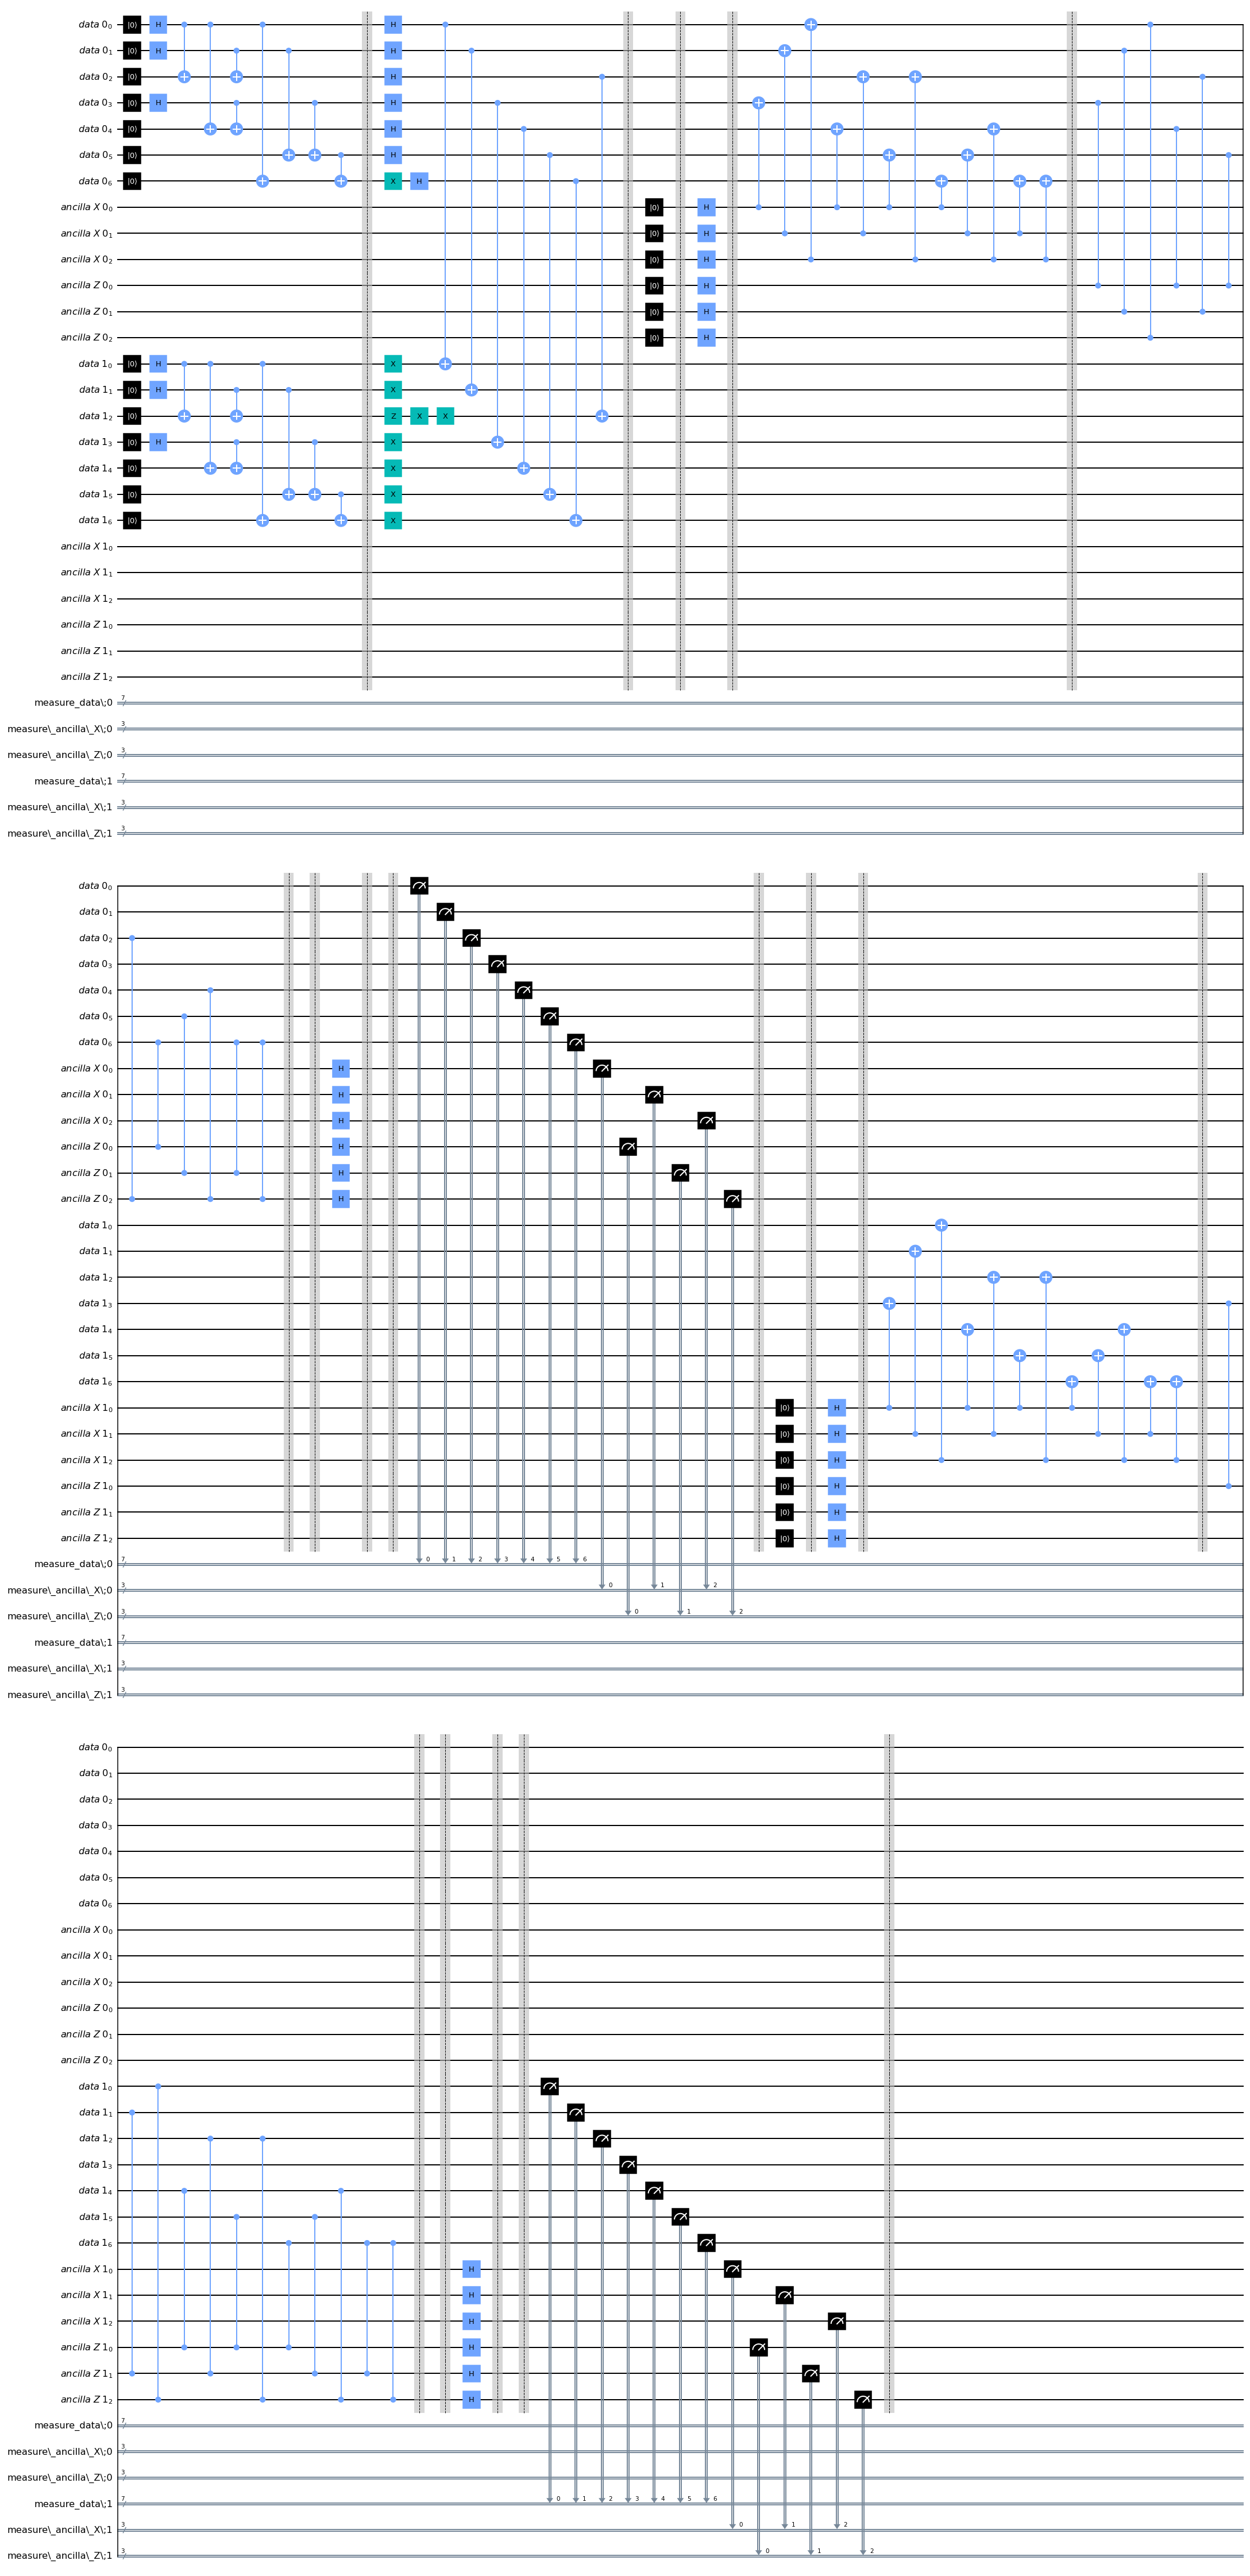

In [11]:
qubit.draw(output='mpl', filename = './circuits/Steane_code_logical_operations_introduce_errors.jpg', fold = 43)